In [4]:
import numpy as np
import jax
import jax.numpy as jnp

from jaxsnn.base import funcutils
from jaxsnn.base import explicit
from jaxsnn.base import implicit

In [5]:
explicit_terms = lambda x: jnp.stack([x[1], -x[0]])
projection = lambda x: x
dt = 1e-2
inner_steps = 20
outer_steps = 200
initial_state = np.ones(2)

In [9]:
time = dt * inner_steps * (1 + np.arange(outer_steps))

equation = explicit.ExplicitConstrainedODE(explicit_terms, projection)
step_fn = explicit.heun_rk2(equation, dt)
integrator = funcutils.trajectory(funcutils.repeated(step_fn, inner_steps), outer_steps)
_, actual = integrator(initial_state)

AttributeError: module 'jaxsnn.base.explicit' has no attribute 'ExplicitConstrainedODE'

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


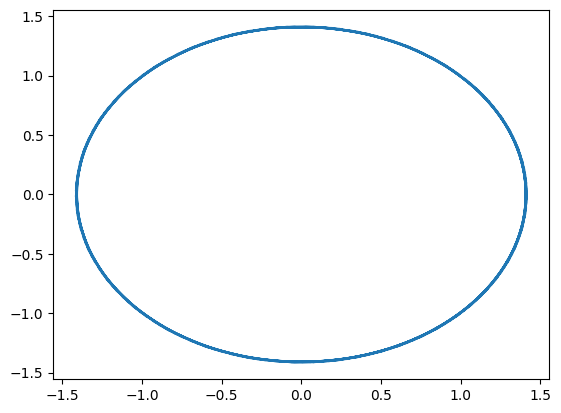

In [ ]:
import matplotlib.pyplot as plt

plt.plot(actual[:, 0], actual[:, 1])
plt.show()

In [5]:
def controlled_dynamics(x, u):
    return jnp.stack([x[1] + u[0], -x[0] + u[1]])


def projection(x, u):
    return x


def output(x, u):
    return x


equation = explicit.ExplicitConstrainedCDE(
    explicit_terms=controlled_dynamics, projection=projection, output=output
)

step_fn = explicit.heun_rk2_cde(equation, dt)

step_fn

<function jaxsnn.base.explicit.constrained_cde_rk.<locals>.step_fn(u0, x0)>

In [9]:
integrator = funcutils.controlled_trajectory(step_fn, np.random.rand(100, 2) > 0.3)
_, actual = integrator(initial_state)

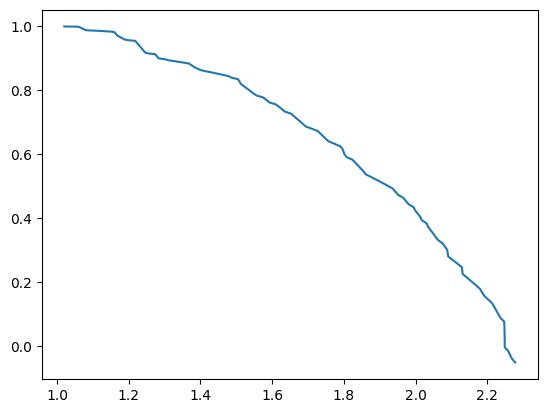

In [10]:
plt.plot(actual[:, 0], actual[:, 1])
plt.show()